# Batch Offline SVD of Feature Subsets

The sparse PCA problem (L0 constraint) is a combinatorial optimization problem. We select k columns (k << n) as a subset of the data matrix, and try to maximize the PCA explained variance (the sum of squares of largest d singular values, d << n). We could greedily select features based on their variance or pairwise covariance (there are common greedy variance cutoffs, such as top 1000 features in bioinformatics). However, there is interplay between the pairwise covariances of 3 or more selected features (the squared singular values are the eigenvalues of the covariance matrix, and the eigenvalues can change dramatically by replacing one column). Sparse PCA with L0 constraint is NP-hard (Berk 2019).

We won't change the asymptotic complexity of each SVD to be done, but we will apply a dramatic speed-up factor. Online algorithms would append data to the data matrix frequently (Ross 2008). To improve on a full recalculation, the update must be orthogonalized using the SVD orthogonal matrices and applied directly to the singular values diagonal matrix. This was left up to the reader, but would have been written for the CPU and serially at the time. A GPU algorithm should be more flat (pack the sparse columns/diagonals into flat arrays, but then process batches in a multi-dimensional array).

We chose bidiagonalization, but not preserving similarity, so that we maintain the sparsity level of the matrix all throughout the process. The bidiagonal matrix is not similar to the original Ross matrix, but its Gram matrix is similar to the Ross matrix's Gram matrix, and the Gram matrix will be tridiagonal (for QR algorithm solution).

### References

Berk, Lauren, and Dimitris Bertsimas. "Certifiably optimal sparse principal component analysis." *Mathematical Programming Computation* 11.3 (2019): 381-420.

Ross, David A., et al. "Incremental learning for robust visual tracking." *International journal of computer vision* 77.1 (2008): 125-141.

In [1]:
from l0pca.ross import bidiagonal_reference, dense_blocks
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt

In [2]:
mat = bidiagonal_reference.sparse_to_dense(dense_blocks.new_random_matrices(1, 7))

# Ross Augmented Singular Values

We have a subproblem SVD singular values (n-1) diagonal matrix. Then, we want to append to the data matrix. There is one dense column (norm of the projection of new data onto the subproblem singular vectors). The new diagonal represents a new orthogonal singular vector, and the norm of the new data along the orthogonalized basis vector.

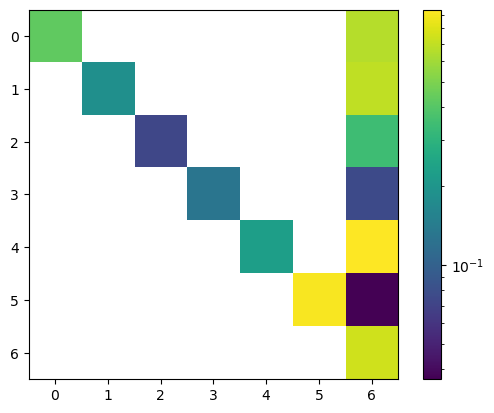

In [3]:
plt.imshow(mat[0], norm=matplotlib.colors.LogNorm())
plt.colorbar()

# Bidiagonal Matrix

This is an example schematic of the expected matrix. We use a decomposition A = U * B * V where B is bidiagonal.

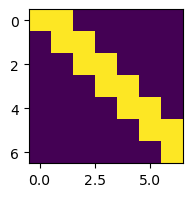

In [4]:
n = 7
schematic = np.eye(n)
schematic[np.arange(n - 1), np.arange(1, n)] = 1
plt.figure(figsize=(2, 2))
plt.imshow(schematic)

# Orthogonal Transformations

Start with U and V as identity, and apply a 2D rotation to either adjacent rows element-wise, or adjacent columns element-wise. Our first goal is to rotate A_1n and A_2n so that A_1n goes to zero (starting to sparsify the appended dense column, and starting from the end that is far from the main diagonal). This is a rotation matrix that is applied elementwise to each column of A, so it must be multiplied on the LHS.

As a side effect, we densified a 2x2 square along the diagonal, which are going to clean up next. In general, our data columns and singular values are already unique, so we are not going to get any cancellations. When we apply a rotation matrix to zero out one entry, any dimension that had only one entry along that location will now have both entries nonzero.

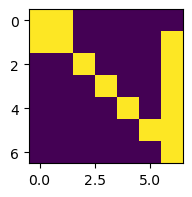

In [5]:
schematic = np.eye(n)
schematic[1:6, -1] = 1
schematic[0:2, 0:2] = 1
plt.figure(figsize=(2, 2))
plt.imshow(schematic)

# Termination

Clean up the diagonal, and keep the upper off-diagonal, using a rotation matrix from the RHS. We plan a rotation on entries A_21 and A_22, and then it is applied to every row in turn. We will see below that there will be intermediate steps between modifying the dense augmented column, and reaching this termination subroutine in the inner loop.

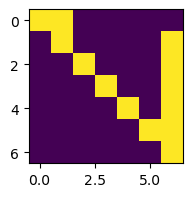

In [6]:
schematic = np.eye(n)
schematic[1:6, -1] = 1
schematic[0, 1] = 1
plt.figure(figsize=(2, 2))
plt.imshow(schematic)

# Initialize Next Diagonal

The LHS rotation will always work similarly to the first one. We'll start highlighting the entries that are read and written on the current step. We will write back to the sparse storage (diagonal array, off-diagonal +1 array, augmented column array). We finish this operation immediately because it will take more than one step to resolve the element that is on the off-diagonal -1.

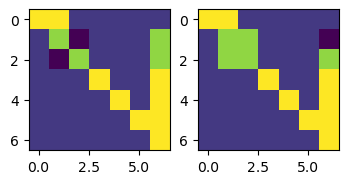

In [7]:
plt.figure(figsize=(4, 2))
schematic = np.eye(n)
schematic[1:6, -1] = 1
schematic[0, 1] = 1
schematic[1:3, 1:3] -= 0.2
schematic[1:3, -1] -= 0.2
plt.subplot(1, 2, 1)
plt.imshow(schematic)
plt.subplot(1, 2, 2)
schematic[1, -1] -= 1
schematic[1, 2] += 1
schematic[2, 1] += 1
plt.imshow(schematic)

# Inner Loop

Now, we start slicing 3 data rows into our storage on each read/write, because the number of nonzero entries in the current column has increased. We apply an RHS rotation where columns 2 and 3 are non-identity, followed by an LHS rotation where rows 1 and 2 are non-identity. Write the 3 rows of data back, and decrement an inner loop counter by 1 until the local variable (off-diagonal entry storage) reaches row 2. Then, we can apply the termination subroutine.

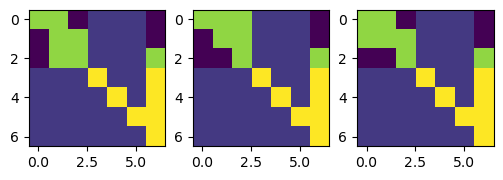

In [8]:
plt.figure(figsize=(6, 2))
schematic = np.eye(n)
schematic[2:6, -1] = 1
schematic[range(0, 2), range(1, 3)] = 1
schematic[2, 1] = 1
schematic[0:3, 0:3] -= 0.2
schematic[0:3, -1] -= 0.2
plt.subplot(1, 3, 1)
plt.imshow(schematic)
plt.subplot(1, 3, 2)
schematic[2, 1] -= 1
schematic[0, 2] += 1
plt.imshow(schematic)
plt.subplot(1, 3, 3)
schematic[0, 2] -= 1
schematic[1, 0] += 1
plt.imshow(schematic)

# Time Complexity

For convenience purposes, this scheme uses O(1) additional storage and O(n^2) time (for each row in turn to become bidiagonalized, the number of operations ramps up from ~1 to ~n).

With increased code complexity, we could permit 2 of the localy modified entries which we described (which are on either the -1 off-diagonal or the +2 off-diagonal) to coexist. Then, we would probably find a way to rotate one such cell down to zero without making any new cell nonzero (reducing the number of non-bidiagonal entries from n to n - 1). This could improve time complexity to O(n). However, when computing this SVD subproblem, we have always started with a main matrix which is O(m * n), and we usually choose n as the smaller dimension, so we accept O(n^2) time complexity here.

# Reference Implementation

NumPy arrays were chosen for a reference implementation because they are mutable. In TensorFlow, making many inner-loop updates in matrix form may cut into performance gains on more typical projects. The packed slices of immutable data that are sliced out in the production TensorFlow implementation will be documented elsewhere.

In [9]:
import importlib
bidiagonal_reference = importlib.reload(bidiagonal_reference)
mat = bidiagonal_reference.sparse_to_dense(dense_blocks.new_random_matrices(1, 7))

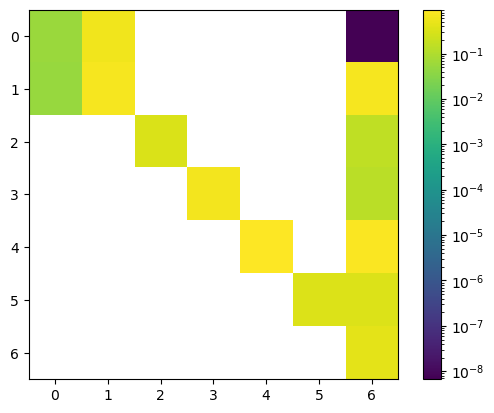

In [10]:
mat = bidiagonal_reference.update_augmented(mat, 0)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

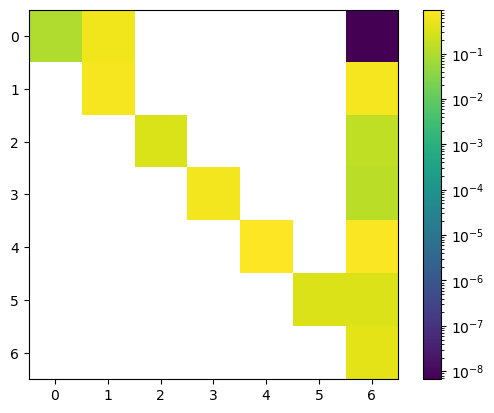

In [11]:
mat = bidiagonal_reference.terminate_temp_value(mat)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

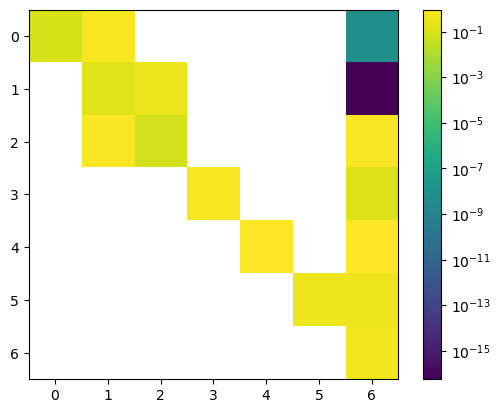

In [12]:
mat = bidiagonal_reference.update_augmented(mat, 1)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

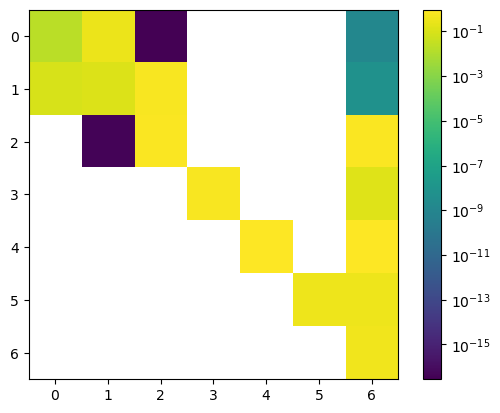

In [13]:
mat = bidiagonal_reference.step_temp_cell(mat, 2, 1)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

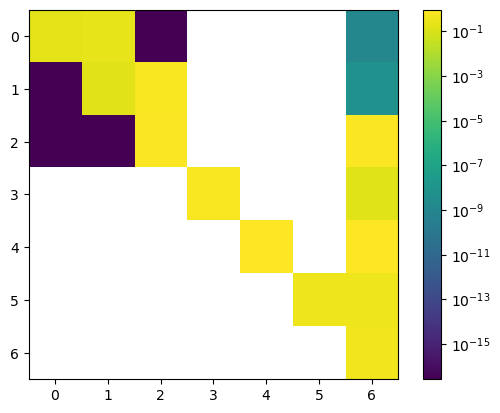

In [14]:
mat = bidiagonal_reference.terminate_temp_value(mat)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

In [15]:
from l0pca.ross import bidiagonal_packed

2022-11-05 18:07:01.231266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 18:07:01.352029: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-05 18:07:01.373812: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-05 18:07:01.789170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [16]:
%%time
mat = dense_blocks.new_random_matrices(1024 * 1024, 9)
bidiagonal_packed.diagonalize_packed_storage(mat)[0].shape

2022-11-05 18:07:02.470646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-05 18:07:02.491797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-05 18:07:02.492398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-05 18:07:02.492846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

CPU times: user 13.5 s, sys: 688 ms, total: 14.2 s
Wall time: 15.7 s


TensorShape([1048576, 3, 9])

In [17]:
%timeit bidiagonal_packed.diagonalize_packed_storage(mat)[0].shape

884 ms ± 8.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%time
mat = dense_blocks.new_random_matrices(1024 * 1024, 8)
bidiagonal_packed.diagonalize_packed_storage(mat)[0].shape

CPU times: user 2.84 s, sys: 90.2 ms, total: 2.93 s
Wall time: 4.13 s


TensorShape([1048576, 3, 8])

In [19]:
%timeit bidiagonal_packed.diagonalize_packed_storage(mat)[0].shape

615 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%time
mat = dense_blocks.new_random_matrices(1024 * 1024, 6)
bidiagonal_packed.diagonalize_packed_storage(mat)[0].shape

CPU times: user 1.78 s, sys: 42.4 ms, total: 1.83 s
Wall time: 2.66 s


TensorShape([1048576, 3, 6])

In [21]:
%timeit bidiagonal_packed.diagonalize_packed_storage(mat)[0].shape

260 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Comparison: Full SVD recalculation performance

Notes: Our bidiagonal matrix requires additional steps (Gram matrix, QR algorithm). Also, there is an intermediate custom solution with minimal code (Gram matrix of original matrix from Ross; built-in eigh method). Therefore, the custom orthogonalization code may be responsible for about a 2X speedup (in user-level code, evaluated against state-of-the-art GpuSolver).

In [23]:
import tensorflow as tf

In [24]:
%timeit tf.linalg.svd(bidiagonal_reference.sparse_to_dense(mat))

2022-11-05 18:20:07.193769: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8b63a90


4.24 s ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
